## Imports and dataset loading

In [ ]:
!pip install pandas numpy matplotlib hyperopt scikit-learn xgboost seaborn sdv nbformat imbalanced-learn

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time
import warnings
from typing import Optional
from collections import Counter

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, STATUS_FAIL
import hyperopt

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import confusion_matrix

from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
import sdv
from sdv.single_table import CTGANSynthesizer
from sdv.metadata import SingleTableMetadata
from sdv.sampling import Condition

print(sdv.version.public)

1.13.1


binary

In [3]:
def process_alarms_bi(df):
    alarm_columns = [col for col in df.columns if col.startswith('alarm')]
    for col in alarm_columns:
        df[col] = df[col].apply(lambda x: 1 if x > 0 else 0)
    return df

df = pd.read_csv('./dataset_TNSM_06995.csv')
df_processed = process_alarms_bi(df)
print('Binarized dataset:')
display(df_processed)

print(f'Number of NaNs: {df_processed.isna().sum().sum()}')

Binarized dataset:


,alarm_0,alarm_1,alarm_2,alarm_3,alarm_4,alarm_5,alarm_6,alarm_7,alarm_8,alarm_9,...,alarm_155,alarm_156,alarm_157,alarm_158,alarm_159,alarm_160,alarm_161,alarm_162,alarm_163,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1664,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,3
1665,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,3
1666,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1667,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


Number of NaNs: 0


Categorical

In [4]:
def process_alarms_cat(df):
    alarm_columns = [col for col in df.columns if col.startswith('alarm')]
    for col in alarm_columns:
        df[col] = df[col].apply(lambda x: 1 if 0 < x <= 45 else (2 if 45 < x <= 450 else (3 if x > 450 else 0)))
    return df

df = pd.read_csv('dataset_alarms_anonymized.csv')
df_processed_cat = process_alarms_cat(df)
print('Quantized dataset:')
display(df_processed_cat)

Quantized dataset:


,alarm_0,alarm_1,alarm_2,alarm_3,alarm_4,alarm_5,alarm_6,alarm_7,alarm_8,alarm_9,...,alarm_155,alarm_156,alarm_157,alarm_158,alarm_159,alarm_160,alarm_161,alarm_162,alarm_163,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1664,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,3
1665,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,3
1666,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1667,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


In [9]:
# Create X matrix and y vector (numpy format)
X_bin, y_bin = df_processed.drop('label', axis=1).to_numpy(), df_processed['label'].to_numpy()
X_cat, y_cat = df_processed_cat.drop('label', axis=1).to_numpy(), df_processed_cat['label'].to_numpy()
X_orig, y_orig = df.drop('label', axis=1).to_numpy(), df['label'].to_numpy()
print(f'X_bin has shape: {X_bin.shape}\ny_bin has shape: {y_bin.shape}\nX_cat has shape: {X_cat.shape}\ny_cat has shape: {y_cat.shape}')

X_bin has shape: (1669, 164)
y_bin has shape: (1669,)
X_cat has shape: (1669, 164)
y_cat has shape: (1669,)


Remark: the two arrays `y_bin` and `y_cat` are the same, we've defined two copies of them for convenience.

In [11]:
# Select only samples of some classes
classes = [0, 3]

mask = df_processed_cat['label'].isin(classes)
X_bin_masked, y_bin_masked = df_processed[mask].drop('label', axis=1).to_numpy(), df_processed[mask]['label'].to_numpy()
y_bin_masked[y_bin_masked == 3] -= 2
print(f'X_bin_masked has shape: {X_bin_masked.shape}\ny_bin_masked has shape: {y_bin_masked.shape}')

X_bin_masked has shape: (851, 164)
y_bin_masked has shape: (851,)


In [15]:
# Undersample to rebalance classes
rus = RandomUnderSampler(random_state=42)
X_bin_resampled, y_bin_resampled = rus.fit_resample(X_bin, y_bin)
X_cat_resampled, y_cat_resampled = rus.fit_resample(X_cat, y_cat)
X_orig_resampled, y_orig_resampled = rus.fit_resample(X_orig, y_orig)
print(f'X_bin_resampled has shape: {X_bin_resampled.shape}\ny_bin_resampled has shape: {y_bin_resampled.shape}\nX_cat_resampled has shape: {X_cat_resampled.shape}\ny_cat_resampled has shape: {y_cat_resampled.shape}\nX_orig_resampled has shape: {X_orig_resampled.shape}\ny_orig_resampled has shape: {y_orig_resampled.shape}')

X_bin_resampled has shape: (828, 164)
y_bin_resampled has shape: (828,)
X_cat_resampled has shape: (828, 164)
y_cat_resampled has shape: (828,)
X_orig_resampled has shape: (828, 164)
y_orig_resampled has shape: (828,)


In [16]:
# Undersample masked data
X_bin_masked_resampled, y_bin_masked_resampled = rus.fit_resample(X_bin_masked, y_bin_masked)
X_bin_masked_resampled.shape, y_bin_masked_resampled.shape
print(f'X_bin_masked_resampled has shape: {X_bin_masked_resampled.shape}\ny_bin_masked_resampled has shape: {y_bin_masked_resampled.shape}')

X_bin_masked_resampled has shape: (672, 164)
y_bin_masked_resampled has shape: (672,)


## Dataset analysis

In [49]:
df_processed.describe()

,alarm_0,alarm_1,alarm_2,alarm_3,alarm_4,alarm_5,alarm_6,alarm_7,alarm_8,alarm_9,...,alarm_155,alarm_156,alarm_157,alarm_158,alarm_159,alarm_160,alarm_161,alarm_162,alarm_163,label
count,1669.000000,1669.000000,1669.000000,1669.000000,1669.000000,1669.0,1669.000000,1669.000000,1669.0,1669.000000,...,1669.000000,1669.0,1669.000000,1669.000000,1669.000000,1669.000000,1669.000000,1669.000000,1669.000000,1669.000000
mean,0.000599,0.026363,0.012582,0.007190,0.002397,0.0,0.064110,0.001198,0.0,0.002996,...,0.083283,0.0,0.009587,0.002397,0.008388,0.002996,0.013781,0.000599,0.016177,1.218095
std,0.024478,0.160261,0.111497,0.084513,0.048911,0.0,0.245023,0.034606,0.0,0.054668,...,0.276393,0.0,0.097470,0.048911,0.091230,0.054668,0.116615,0.024478,0.126195,1.091336
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,0.0,1.000000,...,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000


We can notice that some attributes have always the same value, such as alarm_5. Since these attributes have no impact on the target, we could safely remove them:

In [18]:
# Dropping useless columns
for column in df_processed.columns:
    if (all(df_processed[column] == 0) or all(df_processed[column] == 1)):
        print(f'Dropping dummy column {column}')
        df_processed.drop(column, axis=1, inplace=True)

print('Final dataset shape: ', df_processed.shape)

Final dataset shape:  (1669, 120)


In [19]:
# Dropping useless columns (categorical dataset)
for column in df_processed_cat.columns:
    if np.std(df_processed_cat[column]) == 0:
        print(f'Dropping dummy column {column}')
        df_processed_cat.drop(column, axis=1, inplace=True)

print('Final dataset shape: ', df_processed_cat.shape)

Dropping dummy column alarm_5
Dropping dummy column alarm_8
Dropping dummy column alarm_17
Dropping dummy column alarm_19
Dropping dummy column alarm_20
Dropping dummy column alarm_25
Dropping dummy column alarm_34
Dropping dummy column alarm_36
Dropping dummy column alarm_44
Dropping dummy column alarm_46
Dropping dummy column alarm_47
Dropping dummy column alarm_48
Dropping dummy column alarm_50
Dropping dummy column alarm_53
Dropping dummy column alarm_54
Dropping dummy column alarm_56
Dropping dummy column alarm_61
Dropping dummy column alarm_63
Dropping dummy column alarm_64
Dropping dummy column alarm_71
Dropping dummy column alarm_72
Dropping dummy column alarm_84
Dropping dummy column alarm_85
Dropping dummy column alarm_88
Dropping dummy column alarm_89
Dropping dummy column alarm_92
Dropping dummy column alarm_93
Dropping dummy column alarm_104
Dropping dummy column alarm_106
Dropping dummy column alarm_112
Dropping dummy column alarm_115
Dropping dummy column alarm_119
Dropp

In [ ]:
# Create X matrix and y vector (numpy format)
#X_bin, y_bin = df_processed.drop('label', axis=1).to_numpy(), df_processed['label'].to_numpy()
#X_cat, y_cat = df_processed_cat.drop('label', axis=1).to_numpy(), df_processed_cat['label'].to_numpy()
#print(X_bin.shape, y_bin.shape, X_cat.shape, y_cat.shape)

## Feature selection


In [24]:
# Helper code
input_variables = [v for v in df.columns if v != 'label']
kfolds = StratifiedKFold(10,shuffle=True,random_state=41)

### Baseline

Here we get the baseline score of a linear regression model trained using 10-folds cross-validation, with all the features of the dataset included.

In [25]:
# Binary dataset
baseline_model = LogisticRegression(solver='liblinear')
baseline_scores = cross_val_score(baseline_model, X_bin, y_bin, cv=kfolds)
print("Baseline BIN Model R2 Mean %.3f StdDev %.3f"%(baseline_scores.mean(),baseline_scores.std()))

# Categorical dataset
baseline_model = LogisticRegression(solver='liblinear')
baseline_scores = cross_val_score(baseline_model, X_cat, y_cat, cv=kfolds)
print("Baseline CAT Model R2 Mean %.3f StdDev %.3f"%(baseline_scores.mean(),baseline_scores.std()))

Baseline BIN Model R2 Mean 0.353 StdDev 0.024
Baseline CAT Model R2 Mean 0.345 StdDev 0.018


### Reduced Variance Feature Selection

Now we use `VarianceThreshold` feature selector, trying different values for the features' variance.

In [26]:
from sklearn.feature_selection import VarianceThreshold

variances = [.001, .005, .01, .025, .05, .1, .2]

print(f'Original number of features: {X_bin.shape[1]}')

# Binary dataset
for v in variances:
    print("Variance Threshold = ", v)
    feature_selector = VarianceThreshold(threshold=v)
    X_sel_bin = feature_selector.fit_transform(X_bin)
    mask = feature_selector.get_support()
    print("Reduced binary data set shape = ", X_sel_bin.shape)

    variance_model = LogisticRegression(solver='liblinear')
    variance_scores = cross_val_score(variance_model, X_bin[:,mask], y_bin, cv=kfolds)
    print("Variance Model R2 Mean %.3f StdDev %.3f"%(variance_scores.mean(),variance_scores.std()))

Original number of features: 164
Variance Threshold =  0.001
Reduced binary data set shape =  (1669, 116)
Variance Model R2 Mean 0.353 StdDev 0.024
Variance Threshold =  0.005
Reduced binary data set shape =  (1669, 84)
Variance Model R2 Mean 0.352 StdDev 0.026
Variance Threshold =  0.01
Reduced binary data set shape =  (1669, 72)
Variance Model R2 Mean 0.353 StdDev 0.029
Variance Threshold =  0.025
Reduced binary data set shape =  (1669, 54)
Variance Model R2 Mean 0.355 StdDev 0.024
Variance Threshold =  0.05
Reduced binary data set shape =  (1669, 37)
Variance Model R2 Mean 0.355 StdDev 0.023
Variance Threshold =  0.1
Reduced binary data set shape =  (1669, 21)
Variance Model R2 Mean 0.361 StdDev 0.022
Variance Threshold =  0.2
Reduced binary data set shape =  (1669, 11)
Variance Model R2 Mean 0.365 StdDev 0.015


In [27]:
# Categorical dataset
for v in variances:
    print("Variance Threshold = ", v)
    feature_selector = VarianceThreshold(threshold=v)
    X_sel_cat = feature_selector.fit_transform(X_cat)
    mask = feature_selector.get_support()
    print("Reduced binary data set shape = ", X_sel_cat.shape)

    variance_model = LogisticRegression(solver='liblinear')
    variance_scores = cross_val_score(variance_model, X_cat[:,mask], y_cat, cv=kfolds)
    print("Variance Model R2 Mean %.3f StdDev %.3f"%(variance_scores.mean(),variance_scores.std()))

Variance Threshold =  0.001
Reduced binary data set shape =  (1669, 118)
Variance Model R2 Mean 0.344 StdDev 0.019
Variance Threshold =  0.005
Reduced binary data set shape =  (1669, 104)
Variance Model R2 Mean 0.342 StdDev 0.022
Variance Threshold =  0.01
Reduced binary data set shape =  (1669, 101)
Variance Model R2 Mean 0.342 StdDev 0.021
Variance Threshold =  0.025
Reduced binary data set shape =  (1669, 88)
Variance Model R2 Mean 0.345 StdDev 0.021
Variance Threshold =  0.05
Reduced binary data set shape =  (1669, 75)
Variance Model R2 Mean 0.340 StdDev 0.023
Variance Threshold =  0.1
Reduced binary data set shape =  (1669, 58)
Variance Model R2 Mean 0.352 StdDev 0.018
Variance Threshold =  0.2
Reduced binary data set shape =  (1669, 51)
Variance Model R2 Mean 0.350 StdDev 0.018


### Univariate feature selection

In [28]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

# Binary dataset
k_values = list(range(1, 20, 1))
mean_scores = []
std_scores = []

for k in k_values:
    feature_selection_univariate_model = SelectKBest(mutual_info_classif, k=k)
    X_sel_bin = feature_selection_univariate_model.fit_transform(X_bin, y_bin)
    mask = feature_selection_univariate_model.get_support()
    print("Reduced binary data set shape = ", X_sel_bin.shape)

    univariate_model = LogisticRegression(solver='liblinear')
    univariate_scores = cross_val_score(univariate_model, X_sel_bin, y_bin, cv=kfolds)
    mean_scores.append(univariate_scores.mean())
    std_scores.append(univariate_scores.std())
    print("Univariate Model R2 Mean %.3f StdDev %.3f"%(univariate_scores.mean(), univariate_scores.std()))

Reduced binary data set shape =  (1669, 1)
Univariate Model R2 Mean 0.370 StdDev 0.020
Reduced binary data set shape =  (1669, 2)
Univariate Model R2 Mean 0.365 StdDev 0.003
Reduced binary data set shape =  (1669, 3)
Univariate Model R2 Mean 0.366 StdDev 0.002
Reduced binary data set shape =  (1669, 4)
Univariate Model R2 Mean 0.364 StdDev 0.008
Reduced binary data set shape =  (1669, 5)
Univariate Model R2 Mean 0.362 StdDev 0.015
Reduced binary data set shape =  (1669, 6)
Univariate Model R2 Mean 0.364 StdDev 0.005
Reduced binary data set shape =  (1669, 7)
Univariate Model R2 Mean 0.364 StdDev 0.007
Reduced binary data set shape =  (1669, 8)
Univariate Model R2 Mean 0.362 StdDev 0.012
Reduced binary data set shape =  (1669, 9)
Univariate Model R2 Mean 0.352 StdDev 0.012
Reduced binary data set shape =  (1669, 10)
Univariate Model R2 Mean 0.364 StdDev 0.007
Reduced binary data set shape =  (1669, 11)
Univariate Model R2 Mean 0.362 StdDev 0.014
Reduced binary data set shape =  (1669, 1

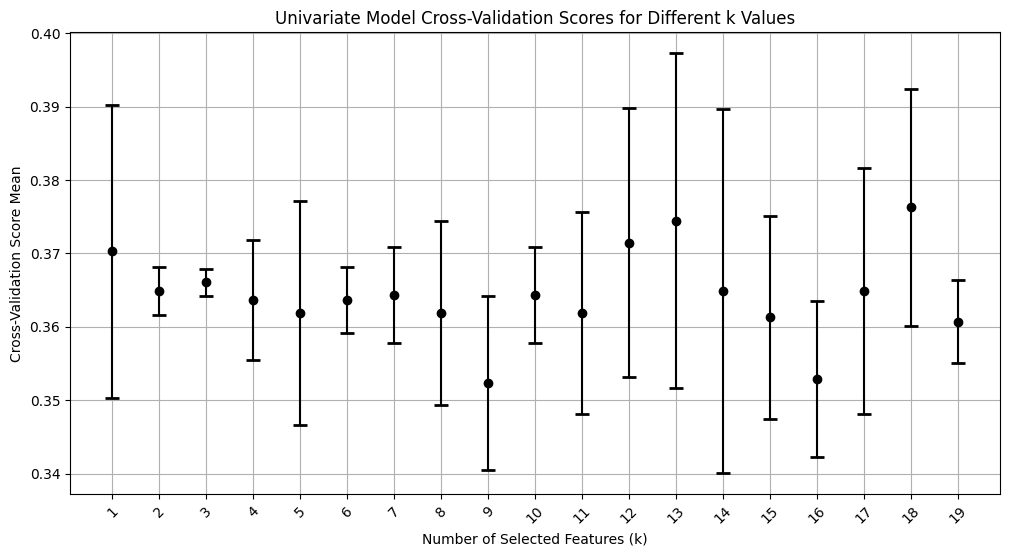

In [29]:
# Create the bar plot of performance vs k
plt.figure(figsize=(12, 6))
plt.errorbar(np.array(k_values), mean_scores, yerr=std_scores, fmt='o', color='black', capsize=5, capthick=2)
plt.xlabel('Number of Selected Features (k)')
plt.ylabel('Cross-Validation Score Mean')
plt.title('Univariate Model Cross-Validation Scores for Different k Values')
plt.xticks(k_values, rotation=45)
plt.grid(True)
plt.show()

In [30]:
# Categorical dataset
mean_scores = []
std_scores = []

for k in k_values:
    feature_selection_univariate_model = SelectKBest(mutual_info_classif, k=k)
    X_sel_cat = feature_selection_univariate_model.fit_transform(X_cat, y_cat)
    mask = feature_selection_univariate_model.get_support()
    print("Reduced binary data set shape = ", X_sel_cat.shape)

    univariate_model = LogisticRegression(solver='liblinear')
    univariate_scores = cross_val_score(univariate_model, X_sel_cat, y_cat, cv=kfolds)
    mean_scores.append(univariate_scores.mean())
    std_scores.append(univariate_scores.std())
    print("Univariate CAT Model R2 Mean %.3f StdDev %.3f"%(univariate_scores.mean(), univariate_scores.std()))

Reduced binary data set shape =  (1669, 1)
Univariate CAT Model R2 Mean 0.365 StdDev 0.003
Reduced binary data set shape =  (1669, 2)
Univariate CAT Model R2 Mean 0.365 StdDev 0.003
Reduced binary data set shape =  (1669, 3)
Univariate CAT Model R2 Mean 0.366 StdDev 0.002
Reduced binary data set shape =  (1669, 4)
Univariate CAT Model R2 Mean 0.361 StdDev 0.007
Reduced binary data set shape =  (1669, 5)
Univariate CAT Model R2 Mean 0.365 StdDev 0.010
Reduced binary data set shape =  (1669, 6)
Univariate CAT Model R2 Mean 0.362 StdDev 0.005
Reduced binary data set shape =  (1669, 7)
Univariate CAT Model R2 Mean 0.360 StdDev 0.020
Reduced binary data set shape =  (1669, 8)
Univariate CAT Model R2 Mean 0.357 StdDev 0.016
Reduced binary data set shape =  (1669, 9)
Univariate CAT Model R2 Mean 0.358 StdDev 0.014
Reduced binary data set shape =  (1669, 10)
Univariate CAT Model R2 Mean 0.363 StdDev 0.009
Reduced binary data set shape =  (1669, 11)
Univariate CAT Model R2 Mean 0.360 StdDev 0.0

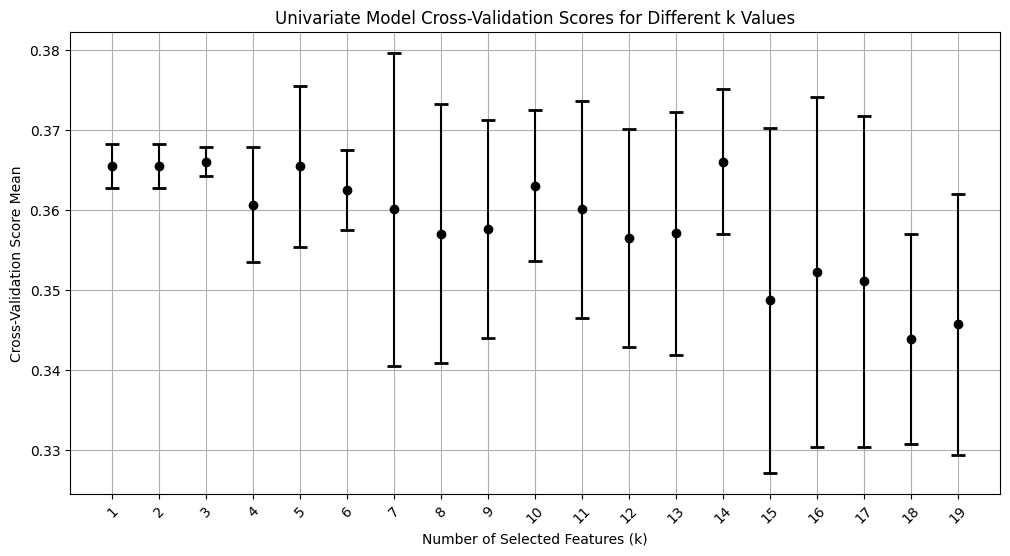

In [31]:
# Create the bar plot of performance vs k
plt.figure(figsize=(12, 6))
plt.errorbar(np.array(k_values), mean_scores, yerr=std_scores, fmt='o', color='black', capsize=5, capthick=2)
plt.xlabel('Number of Selected Features (k)')
plt.ylabel('Cross-Validation Score Mean')
plt.title('Univariate Model Cross-Validation Scores for Different k Values')
plt.xticks(k_values, rotation=45)
plt.grid(True)
plt.show()

### PCA

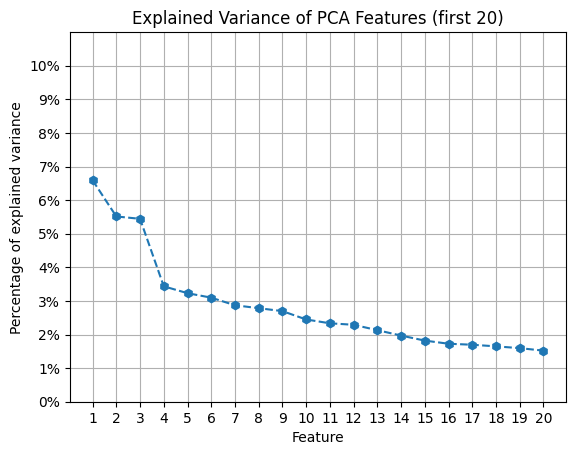

In [36]:
# Binary dataset

full_pca_model = PCA()
X_std = StandardScaler().fit_transform(X_bin)   # necessary step for PCA
full_fitted_model = full_pca_model.fit(X_std)   # all principal components

# Plot the explained variance ratio
plt.plot(full_fitted_model.explained_variance_ratio_[:20], '--h');
plt.xticks(np.arange(0,13,1),labels=np.arange(1,14,1));
plt.xlabel("Feature");
plt.ylabel("Percentage of explained variance");
plt.xticks(np.arange(0,20,1),labels=np.arange(1,21,1));
plt.yticks(np.arange(0.0,0.11,.01),labels=["%.0f%%"%(x*100) for x in np.arange(0.0,0.11,.01)]);
plt.ylim([0.0,0.11])
plt.title("Explained Variance of PCA Features (first 20)")
plt.grid(True)
plt.show()

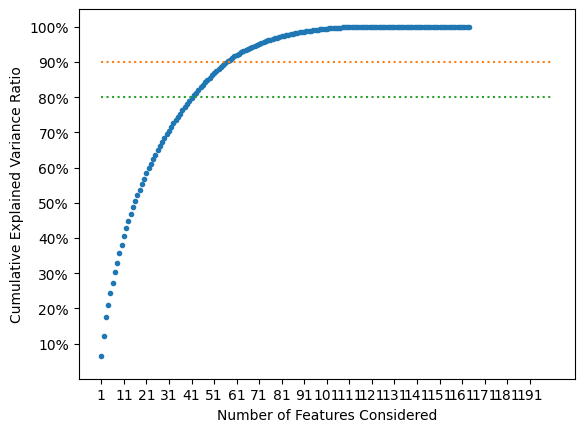

In [38]:
# Plot the cumulative explained variance ratio
plt.plot(full_fitted_model.explained_variance_ratio_.cumsum(), '.');
plt.xticks(np.arange(0,200,10),labels=np.arange(1,201,10));
plt.yticks(np.arange(0.1,1.1,.1),labels=["%.0f%%"%(x*100) for x in np.arange(0.1,1.1,.1)]);
plt.ylim([0,1.05]);
plt.plot([0,200],[.9,.9],':');
plt.plot([0,200],[.8,.8],':');
plt.xlabel("Number of Features Considered");
plt.ylabel("Cumulative Explained Variance Ratio");

In [42]:
# We now select the number of principal components that explain 80% of the variance
feature_selection_pca_model = PCA(n_components=0.8)
fitted_model = feature_selection_pca_model.fit(X_std)

X_selected_features_pca = fitted_model.transform(X_std)
print("Explained Variance = %.3f" % fitted_model.explained_variance_ratio_.cumsum()[-1])
print("Reduced data set shape =",X_selected_features_pca.shape)

pca_model = LogisticRegression()
pca_scores = cross_val_score(pca_model, X_selected_features_pca, y_bin, cv=kfolds)
pca_scores.mean()
print("PCA Model R2 Mean %.3f StdDev %.3f"%(pca_scores.mean(),pca_scores.std()))

Explained Variance = 0.805
Reduced data set shape = (1669, 42)
PCA Model R2 Mean 0.357 StdDev 0.024


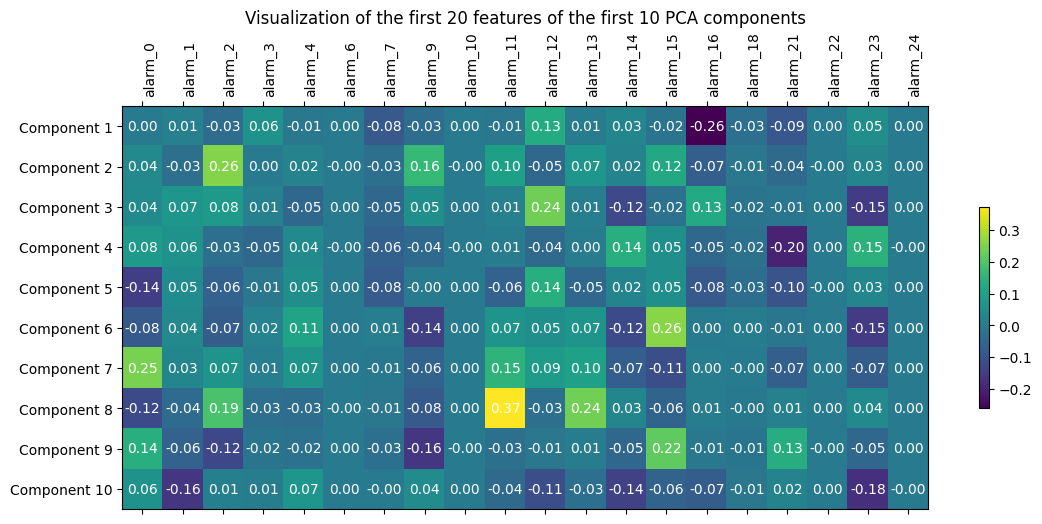

In [77]:
# Visualize the first 20 features of the first 10 PCA components
number_of_components = 10
number_of_variables = 20
component_ticks = np.arange(0, number_of_components, 1)
component_labels = ['Component ' + str(x + 1) for x in component_ticks]

plt.figure(figsize=(number_of_components * 1.3, number_of_variables * 1.3))
plt.matshow(feature_selection_pca_model.components_[:number_of_components, :number_of_variables], cmap='viridis', fignum=1)
plt.yticks(component_ticks, labels=component_labels)
plt.colorbar(shrink=0.1)
plt.grid(False)
plt.xticks(range(number_of_variables), input_variables[:number_of_variables], rotation=90, ha='left')

for (i, j), z in np.ndenumerate(feature_selection_pca_model.components_[:number_of_components, :number_of_variables]):
    plt.text(j, i, '{:0.2f}'.format(z), ha='center', va='center', color="white", fontsize=10)

plt.title('Visualization of the first 20 features of the first 10 PCA components')
plt.show()


###  L1 regularization (embedded approach)

In [79]:
# We now use a regularization model (Logistic Regression with L1 regularization) to select the best features
C_values = np.logspace(-4, 4, 20)  # Regularization strength
mean_scores = []
std_scores = []

for C in C_values:
    lasso_model = LogisticRegression(penalty='l1', solver='liblinear', C=C)
    lasso_model.fit(X_bin, y_bin)

    # Cross-validation with the selected features
    univariate_scores = cross_val_score(lasso_model, X_bin, y_bin, cv=kfolds)
    mean_scores.append(univariate_scores.mean())
    std_scores.append(univariate_scores.std())
    print("Univariate Model R2 Mean %.3f StdDev %.3f" % (univariate_scores.mean(), univariate_scores.std()))

Univariate Model R2 Mean 0.309 StdDev 0.003
Univariate Model R2 Mean 0.309 StdDev 0.003
Univariate Model R2 Mean 0.309 StdDev 0.003
Univariate Model R2 Mean 0.309 StdDev 0.003
Univariate Model R2 Mean 0.366 StdDev 0.002
Univariate Model R2 Mean 0.366 StdDev 0.002
Univariate Model R2 Mean 0.366 StdDev 0.002
Univariate Model R2 Mean 0.365 StdDev 0.013
Univariate Model R2 Mean 0.376 StdDev 0.016
Univariate Model R2 Mean 0.359 StdDev 0.024
Univariate Model R2 Mean 0.349 StdDev 0.024
Univariate Model R2 Mean 0.348 StdDev 0.022
Univariate Model R2 Mean 0.347 StdDev 0.025
Univariate Model R2 Mean 0.345 StdDev 0.026
Univariate Model R2 Mean 0.340 StdDev 0.024
Univariate Model R2 Mean 0.341 StdDev 0.026
Univariate Model R2 Mean 0.342 StdDev 0.025
Univariate Model R2 Mean 0.342 StdDev 0.026
Univariate Model R2 Mean 0.342 StdDev 0.026
Univariate Model R2 Mean 0.341 StdDev 0.025


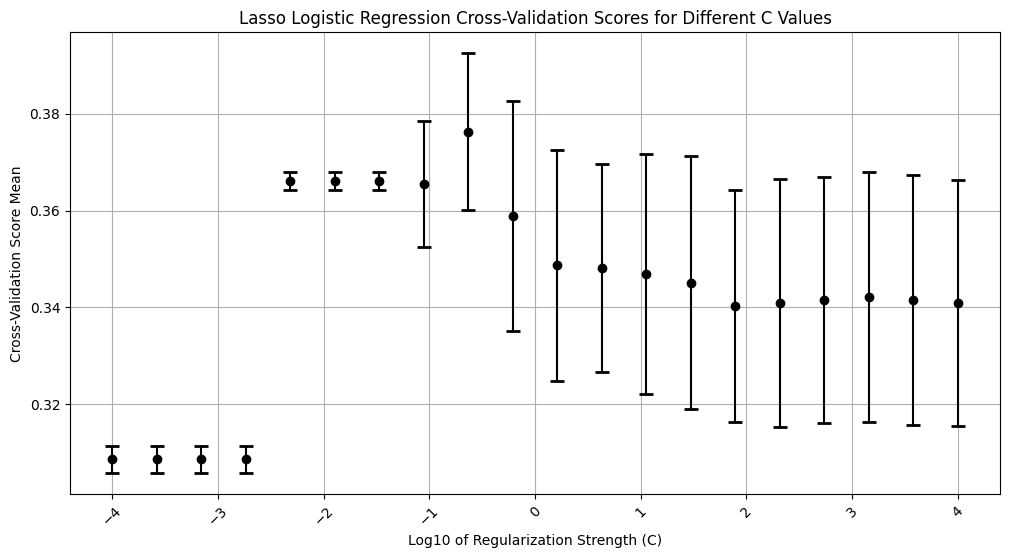

In [80]:
plt.figure(figsize=(12, 6))
plt.errorbar(np.log10(C_values), mean_scores, yerr=std_scores, fmt='o', color='black', capsize=5, capthick=2)
plt.xlabel('Log10 of Regularization Strength (C)')
plt.ylabel('Cross-Validation Score Mean')
plt.title('Lasso Logistic Regression Cross-Validation Scores for Different C Values')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Recursive Feature Elimination

In [83]:
# Recursive Feature Elimination
def select_features(X, y):
    model = LogisticRegression(solver='liblinear')
    rfe = RFE(model, n_features_to_select=40)
    fit = rfe.fit(X, y)
    X_sel_bin = rfe.transform(X)
    return rfe.get_support(), X_sel_bin

selected_features_bin, X_sel_bin = select_features(X_bin, y_bin)
selected_features_cat, X_sel_cat = select_features(X_cat, y_cat)

# Transform the feature matrices
#X_bin = X_bin[:, selected_features_bin]
#X_cat = X_cat[:, selected_features_cat]

# Add the label to the mask
selected_features_bin = np.concatenate([selected_features_bin, [True]])  
selected_features_cat = np.concatenate([selected_features_cat, [True]])  

print(df_processed.iloc[:, selected_features_bin])
print(df_processed_cat.iloc[:, selected_features_cat])

IndexError: Boolean index has wrong length: 165 instead of 120

## kNN Classifier Training

In [84]:
# Parameters of the search space
NEIGHBORS = range(1, 10)
WEIGHTS = ['uniform', 'distance']

In [86]:
def optimize_KNN(X_train, y_train, k=5):
#Inputs: - X_train: training set (features)
#        - y_train: training set (ground truth labels)
#        - data_gen_func: function that generates (possibly) synthetic data for training
#Output: - knn: model to be returned by the function
#        - best_cv_f1: crossvalidation F1 score obtained with the best hyperparameters

    # Search space for KNN
    space4knn = {
     'neighb': hp.choice('neighb', NEIGHBORS),
     'wgts': hp.choice('wgts', WEIGHTS),
    }

    # Hyperopt objective function = KNN crossvalidation F1 score
    def hyperopt_train_test(params):
        scores = []
        kf = StratifiedKFold(n_splits=k, random_state=42, shuffle=True)
        for i, (train_index, test_index) in enumerate(kf.split(X_train, y_train)):
            X_train_cv, X_test_cv = X_train[train_index], X_train[test_index]
            y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]

            # Instantiate and fit model, calculate accuracy on cross-validation set
            model = KNeighborsClassifier(n_neighbors=params['neighb'], weights=params['wgts'])
            model.fit(X_train_cv, y_train_cv)
            y_pred = model.predict(X_test_cv)
            f1 = f1_score(y_test_cv, y_pred, average='weighted')
            scores.append(f1)

        return np.mean(scores)

    # Used in fmin
    def f(params):
        f1 = hyperopt_train_test(params)
        return {'loss': -f1, 'status': STATUS_OK}

    trials = Trials()

    ta = time.time()
    best_params = fmin(f, space4knn, algo=tpe.suggest, max_evals=100, trials=trials)
    tb = time.time()
    best_params = hyperopt.space_eval(space4knn, best_params)
    #F: this is used to extract from space4rf the best values
    #   according to the indexes in best_params (and put such values in best_params)

    best_cv_f1 = -trials.best_trial['result']['loss'] #F: best across trials
    print('best cross-validation F1 score: ' + str(best_cv_f1))
    print('Crossvalidation duration for KNN is {} s\n'.format(round(tb - ta)))

    # Train the model with the best hyperparameters    
    knn = KNeighborsClassifier(n_neighbors=best_params['neighb'], weights=best_params['wgts'])

    t0 = time.time()
    knn.fit(X_train, y_train)
    t1 = time.time()

    print('Best number of neighbors: {}\n'.format(best_params['neighb']))
    print('Best weight function: {}\n'.format(best_params['wgts']))
    print('Crossvalidation accuracy: {}\n'.format(best_cv_f1))
    print('Training duration for KNN is {} s\n'.format(round(t1 - t0)))

    return knn, best_cv_f1

## Random forest classifier training

In [ ]:
# Parameters of the search space
N_ESTIMATORS_RF = range(1, 5000)
SPLIT_CRITERIA = ['gini', 'entropy']
MAX_DEPTH_RF = range(1, 50)

In [11]:
def optimize_RF(X_train, y_train, k=5):
#Inputs: - X_train: training set (features)
#        - y_train: training set (ground truth labels)
#        - data_gen_func: function that generates (possibly) synthetic data for training
#Output: - rf: model to be returned by the function
#        - best_cv_f1: crossvalidation F1 score obtained with the best hyperparameters

    # Search space for RF
    space4rf = {
     'estimators': hp.choice('estimators', N_ESTIMATORS_RF),
     'crit': hp.choice('crit', SPLIT_CRITERIA),
     'maxd': hp.choice('maxd', MAX_DEPTH_RF),
    }

    # Hyperopt objective function = RF crossvalidation F1 score
    def hyperopt_train_test_rf(params):
        scores = []
        kf = StratifiedKFold(n_splits=k, random_state=42, shuffle=True)
        for i, (train_index, test_index) in enumerate(kf.split(X_train, y_train)):
            X_train_cv, X_test_cv = X_train[train_index], X_train[test_index]
            y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]

            # Instantiate and fit model, calculate accuracy on cross-validation set
            model = RandomForestClassifier(n_estimators=params['estimators'], criterion=params['crit'],
                                       max_depth=params['maxd'], class_weight='balanced')
            model.fit(X_train_cv, y_train_cv)
            y_pred = model.predict(X_test_cv)
            f1 = f1_score(y_test_cv, y_pred, average='weighted')
            scores.append(f1)

        return np.mean(scores)
    
    def f(params):
        f1 = hyperopt_train_test_rf(params)
        return {'loss': -f1, 'status': STATUS_OK}

    trials = Trials()

    ta = time.time()
    best_params = fmin(f, space4rf, algo=tpe.suggest, max_evals=20, trials=trials)
    tb = time.time()
    print(best_params)

    best_params = hyperopt.space_eval(space4rf, best_params)
    print(best_params)

    best_cv_f1 = -round(trials.best_trial['result']['loss'], 2) #F: best across trials
    print('best cross-validation F1 score: ' + str(best_cv_f1))
    print('Crossvalidation duration for RF is {} s\n'.format(round(tb - ta)))

    # Train the model with the best hyperparameters
    rf = RandomForestClassifier(n_estimators=best_params['estimators'], criterion=best_params['crit'],
                                       max_depth=best_params['maxd'], class_weight='balanced')

    t0 = time.time()
    rf.fit(X_train, y_train)
    t1 = time.time()

    print('Best number of estimators: {}\n'.format(best_params['estimators']))
    print('Best splitting criterion: {}\n'.format(best_params['crit']))
    print('Best max_depth: {}\n'.format(best_params['maxd']))
    print('Crossvalidation accuracy: {}\n'.format(best_cv_acc))
    print('Training duration for RF is {} s\n'.format(round(t1 - t0)))

    # Plot accuracies for each hyperparameter combination
    for t in trials.trials:
        plt.scatter(t['tid'], -t['result']['loss'])
        plt.xticks(range(len(trials.trials)), range(len(trials.trials)))

    return rf, best_cv_f1


In [12]:
'''from itertools import product

def optimize_RF(X_train, y_train, k=5):
    estimators = [10, 50, 100, 200, 500, 2000, 10000]
    crit = ['gini', 'entropy']
    maxd = [3, 15, 100, None]

    scores = {}

    for estimator, criterion, max_depth in product(estimators, crit, maxd):
        model = RandomForestClassifier(n_estimators=estimator, criterion=criterion, max_depth=max_depth, class_weight='balanced')
        f1 = cross_val_score(model, X_train, y_train, cv=k, scoring='f1_weighted').mean()
        print(f'Estimators: {estimator}, Criterion: {criterion}, Max Depth: {max_depth}, F1: {f1}')
        scores[(estimator, criterion, max_depth)] = f1

    best_params = max(scores, key=scores.get)
    best_cv_f1 = scores[best_params]
    print('Best hyperparameters:', best_params)
    print('Best CV f1:', best_cv_f1)

    final_model = RandomForestClassifier(n_estimators=best_params[0], criterion=best_params[1], max_depth=best_params[2], class_weight='balanced')
    final_model.fit(X_train, y_train)

    return final_model, best_cv_f1'''

## XGBoost Classifier training

In [87]:
# Parameters of the search space
N_ESTIMATORS_XGB = range(1, 5000)
MAX_DEPTH_XGB = range(1, 50)
SUBSAMPLE = np.arange(0.1, 1, 0.01)

In [88]:
def optimize_XGB(X_train, y_train, k=5):
#Inputs: - X_train: training set (features)
#        - y_train: training set (ground truth labels)
#        - data_gen_func: function that generates (possibly) synthetic data for training
#Output: - rf: model to be returned by the function
#        - best_cv_f1: crossvalidation F1 score obtained with the best hyperparameters

    # Search space for XGB
    space4xgb = {
     'estimators': hp.choice('estimators', N_ESTIMATORS_XGB),
     'max_depth': hp.choice('max_depth', MAX_DEPTH_XGB),
     'subsample': hp.choice('subsample', SUBSAMPLE),
    }

    def hyperopt_train_test_rf(params):
        scores = []
        kf = StratifiedKFold(n_splits=k, random_state=42, shuffle=True)
        for i, (train_index, test_index) in enumerate(kf.split(X_train, y_train)):
            X_train_cv, X_test_cv = X_train[train_index], X_train[test_index]
            y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]

            # Instantiate and fit model, calculate accuracy on cross-validation set
            model = XGBClassifier(n_estimators=params['estimators'], max_depth=params['max_depth'], subsample=params['subsample'])
            model.fit(X_train_cv, y_train_cv)
            y_pred = model.predict(X_test_cv)
            f1 = f1_score(y_test_cv, y_pred, average='weighted')
            scores.append(f1)

        return np.mean(scores)
    
    def f(params):
        f1 = hyperopt_train_test_rf(params)
        return {'loss': -f1, 'status': STATUS_OK}

    trials = Trials()

    # Crossvalidation
    ta = time.time()
    best_params = fmin(f, space4xgb, algo=tpe.suggest, max_evals=20, trials=trials)
    tb = time.time()
    print(best_params)

    best_params = hyperopt.space_eval(space4xgb, best_params)
    print(best_params)

    best_cv_f1 = -round(trials.best_trial['result']['loss'], 2) #F: best across trials
    print('best_cv_acc: ' + str(best_cv_f1))
    print('Crossvalidation duration for RF is {} s\n'.format(round(tb - ta)))

    # Train the model with the best hyperparameters
    final_xgb = XGBClassifier(n_estimators=best_params['estimators'], max_depth=best_params['max_depth'], subsample=best_params['subsample'])

    t0 = time.time()
    final_xgb.fit(X_train, y_train)
    t1 = time.time()

    print('Best number of estimators: {}\n'.format(best_params['estimators']))
    print('Best max depth: {}\n'.format(best_params['max_depth']))
    print('Best subsample rate: {}\n'.format(best_params['subsample']))
    print('Crossvalidation F1 score: {}\n'.format(best_cv_f1))
    print('Training duration for RF is {} s\n'.format(round(t1 - t0)))

    # Plot accuracies for each hyperparameter combination
    for t in trials.trials:
        plt.scatter(t['tid'], -t['result']['loss'])
        plt.xticks(range(len(trials.trials)), range(len(trials.trials)))

    return final_xgb, best_cv_f1


## Multi-layer-perceptron training

In [91]:
# Parameters of the search space
HIDDEN_LAYER_SIZES = [(50,), (100,), (50, 50), (100, 100), (100, 100, 100), (100, 100, 100, 100)]
ACTIVATION_FUNCTIONS = ['identity', 'logistic', 'tanh', 'relu']
SOLVERS = ['lbfgs', 'sgd', 'adam']
ALPHAS = np.logspace(-5, 0, 10)
LEARNING_RATES = ['constant', 'invscaling', 'adaptive']

In [92]:
def optimize_MLP(X_train, y_train, k=5):
    # Inputs: - X_train: training set (features)
    #         - y_train: training set (ground truth labels)
    #         - data_gen_func: function that generates (possibly) synthetic data for training
    # Output: - mlp: model to be returned by the function
    #         - best_cv_f1: crossvalidation F1 score obtained with the best hyperparameters

    # Define the search space for your hyperparameters
    space4mlp = {
        'hidden_layer_sizes': hp.choice('hidden_layer_sizes', HIDDEN_LAYER_SIZES),
        'activation': hp.choice('activation', ACTIVATION_FUNCTIONS),
        'solver': hp.choice('solver', SOLVERS),
        'alpha': hp.choice('alpha', ALPHAS),
        'learning_rate': hp.choice('learning_rate', LEARNING_RATES),
    }

    def hyperopt_train_test_mlp(params):
        print(params)

        scores = []
        kf = StratifiedKFold(n_splits=k, random_state=42, shuffle=True)
        for i, (train_index, test_index) in enumerate(kf.split(X_train, y_train)):
            X_train_cv, X_test_cv = X_train[train_index], X_train[test_index]
            y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]

            # Instantiate and fit model, calculate accuracy on cross-validation set
            with warnings.catch_warnings(record=True) as w:
                warnings.simplefilter("always")
                model = MLPClassifier(hidden_layer_sizes=params['hidden_layer_sizes'], activation=params['activation'],
                                    solver=params['solver'], alpha=params['alpha'],
                                    learning_rate=params['learning_rate'], max_iter=5000)
                model.fit(X_train_cv, y_train_cv)
                y_pred = model.predict(X_test_cv)
                f1 = f1_score(y_test_cv, y_pred, average='weighted')
                scores.append(f1)

                # Check for warnings
                if len(w) > 0:
                    for warning in w:
                        print(str(warning.message))

        return np.mean(scores), len(w) == 0   # True if no warnings

    def f(params):  # This function is used below, as a parameter to fmin
        f1, status = hyperopt_train_test_mlp(params)
        return {'loss': -f1, 'status': STATUS_OK if status else STATUS_FAIL} # Status is OK if no warnings
    trials = Trials()

    ta = time.time()
    best_params = fmin(f, space4mlp, algo=tpe.suggest, max_evals=20, trials=trials)
    tb = time.time()
    print(best_params)

    best_params = hyperopt.space_eval(space4mlp, best_params)
    print(best_params)

    best_cv_f1 = -round(trials.best_trial['result']['loss'], 2)  # best across trials
    print('best_cv_f1: ' + str(best_cv_f1))
    print('Crossvalidation duration for MLP is {} s\n'.format(round(tb - ta)))

    # Train the model with the best hyperparameters
    mlp = MLPClassifier(hidden_layer_sizes=best_params['hidden_layer_sizes'], activation=best_params['activation'],
                        solver=best_params['solver'], alpha=best_params['alpha'],
                        learning_rate=best_params['learning_rate'], max_iter=2000)

    t0 = time.time()
    mlp.fit(X_train, y_train)
    t1 = time.time()

    print('Best hidden_layer_sizes: {}\n'.format(best_params['hidden_layer_sizes']))
    print('Best activation function: {}\n'.format(best_params['activation']))
    print('Best solver: {}\n'.format(best_params['solver']))
    print('Best alpha: {}\n'.format(best_params['alpha']))
    print('Best learning rate: {}\n'.format(best_params['learning_rate']))
    print('Crossvalidation F1 score: {}\n'.format(best_cv_f1))
    print('Training duration for MLP is {} s\n'.format(round(t1 - t0)))

    # Plot accuracies for each hyperparameter combination
    for t in trials.trials:
        plt.scatter(t['tid'], -t['result']['loss'])
        plt.xticks(range(len(trials.trials)), range(len(trials.trials)))

    return mlp, best_cv_f1


## SVM training

In [ ]:
# Parameters of the search space
C_VALUES = np.logspace(-12, 6, 10)
GAMMAS = np.logspace(-8, 6, 10)

In [15]:
def optimize_SVM(X_train, y_train, k=5):
    # Inputs: - X_train: training set (features)
    #         - y_train: training set (ground truth labels)
    #         - k: number of folds for cross-validation
    # Output: - svm: model to be returned by the function
    #         - best_cv_f1: crossvalidation F1 score obtained with the best hyperparameters
    
    # Search space for SVM
    space4svm = {
        'C': hp.choice('C', C_VALUES),
        'gamma': hp.choice('gamma', GAMMAS)
    }

    def hyperopt_train_test_svm(params):
        scores = []
        kf = StratifiedKFold(n_splits=k, random_state=42, shuffle=True)
        for train_index, test_index in kf.split(X_train, y_train):
            X_train_cv, X_test_cv = X_train[train_index], X_train[test_index]
            y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]

            # Instantiate and fit model, calculate accuracy on cross-validation set
            with warnings.catch_warnings(record=True) as w:
                warnings.simplefilter("always")
                model = SVC(C=params['C'], gamma=params['gamma'], kernel='sigmoid')
                model.fit(X_train_cv, y_train_cv)
                y_pred = model.predict(X_test_cv)
                f1 = f1_score(y_test_cv, y_pred, average='weighted')
                scores.append(f1)

                # Check for warnings
                if len(w) > 0:
                    for warning in w:
                        print(str(warning.message))

        return np.mean(scores), len(w) == 0  # True if no warnings

    def f(params):  # This function is used below, as a parameter to fmin
        f1, status = hyperopt_train_test_svm(params)
        return {'loss': -f1, 'status': STATUS_OK if status else STATUS_FAIL}  # Status is OK if no warnings

    trials = Trials()
    ta = time.time()
    best_params = fmin(f, space4svm, algo=tpe.suggest, max_evals=50, trials=trials)
    tb = time.time()
    print(best_params)

    best_params = hyperopt.space_eval(space4svm, best_params)
    print(best_params)

    best_cv_f1 = -round(trials.best_trial['result']['loss'], 2)  # best across trials
    print('best_cv_acc: ' + str(best_cv_f1))
    print('Crossvalidation duration for SVM is {} s\n'.format(round(tb - ta)))

    svm = SVC(C=best_params['C'], gamma=best_params['gamma'], kernel='rbf')

    t0 = time.time()
    svm.fit(X_train, y_train)
    t1 = time.time()

    print('Best C: {}\n'.format(best_params['C']))
    print('Best gamma: {}\n'.format(best_params['gamma']))
    print('Crossvalidation F1 Score: {}\n'.format(best_cv_f1))
    print('Training duration for SVM is {} s\n'.format(round(t1 - t0)))

    # Plot accuracies for each hyperparameter combination
    plt.figure(figsize=(10, 6))
    for t in trials.trials:
        plt.scatter(t['tid'], -t['result']['loss'], label=f"Trial {t['tid']}")
    plt.xlabel("Trial")
    plt.ylabel("Accuracy")
    plt.title("Hyperopt Trials")
    plt.legend()
    plt.show()

    return svm, best_cv_f1


## Visualization of the data

### PCA

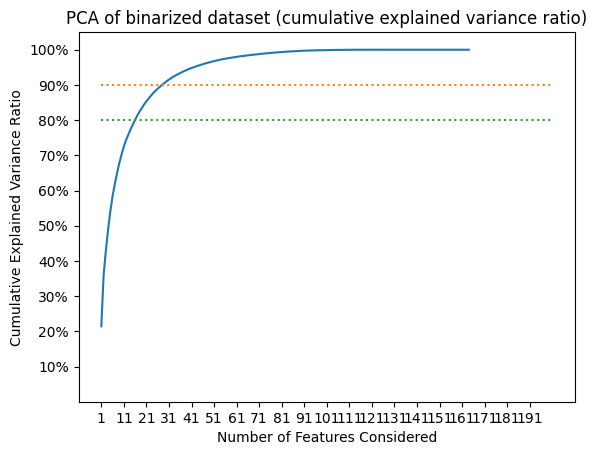

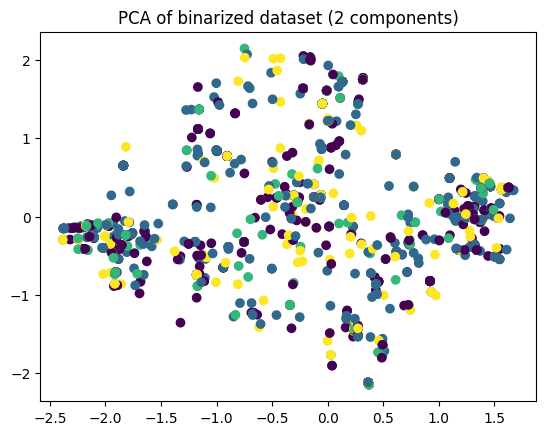

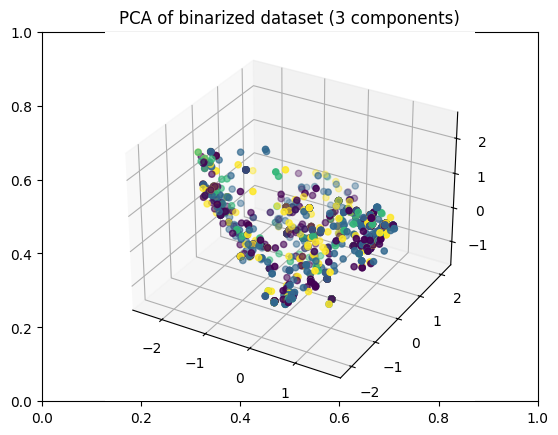

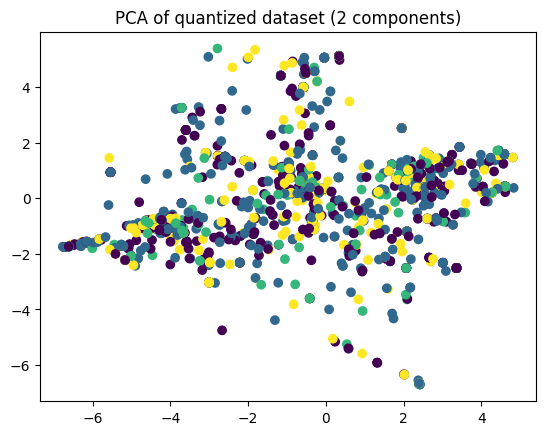

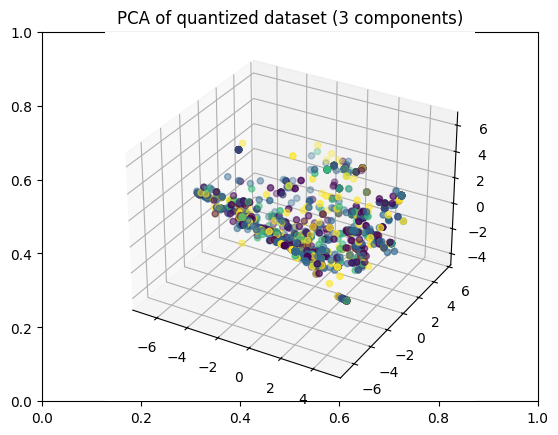

In [97]:
pca_model = PCA()
X_bin_pca = pca_model.fit_transform(X_bin)
X_bin_pca.shape
# Plot the cumulative explained variance ratio
plt.title('PCA of binarized dataset (cumulative explained variance ratio)')
plt.plot(np.cumsum(pca_model.explained_variance_ratio_))
plt.xticks(np.arange(0,200,10),labels=np.arange(1,201,10));
plt.yticks(np.arange(0.1,1.1,.1),labels=["%.0f%%"%(x*100) for x in np.arange(0.1,1.1,.1)]);
plt.ylim([0,1.05]);
plt.plot([0,200],[.9,.9],':');
plt.plot([0,200],[.8,.8],':');
plt.xlabel("Number of Features Considered");
plt.ylabel("Cumulative Explained Variance Ratio");

# Visualize the first two components
plt.figure()
plt.title('PCA of binarized dataset (2 components)')
plt.scatter(X_bin_pca[:, 0], X_bin_pca[:, 1], c=y_bin)

# Visualize the first three components
from mpl_toolkits.mplot3d import Axes3D
plt.figure()
plt.title('PCA of binarized dataset (3 components)')
ax = plt.axes(projection='3d')
ax.scatter(X_bin_pca[:, 0], X_bin_pca[:, 1], X_bin_pca[:, 2], c=y_bin)

# Quantized dataset
pca_model = PCA(n_components=0.9)
X_cat_pca = pca_model.fit_transform(X_cat)

# Visualize the first two components
plt.figure()
plt.title('PCA of quantized dataset (2 components)')
plt.scatter(X_cat_pca[:, 0], X_cat_pca[:, 1], c=y_cat)

# Visualize the first three components
from mpl_toolkits.mplot3d import Axes3D
plt.figure()
plt.title('PCA of quantized dataset (3 components)')
ax = plt.axes(projection='3d')
ax.scatter(X_cat_pca[:, 0], X_cat_pca[:, 1], X_cat_pca[:, 2], c=y_cat);

### t-SNE

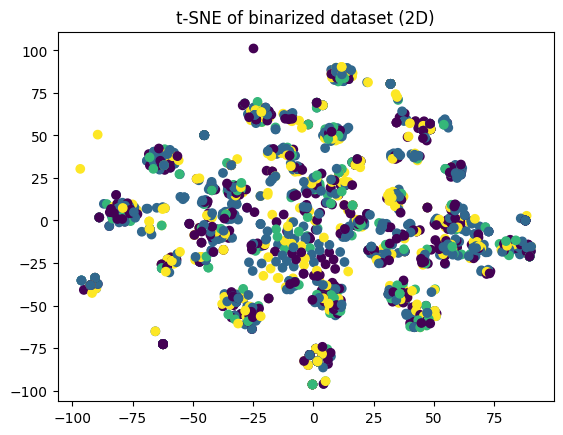

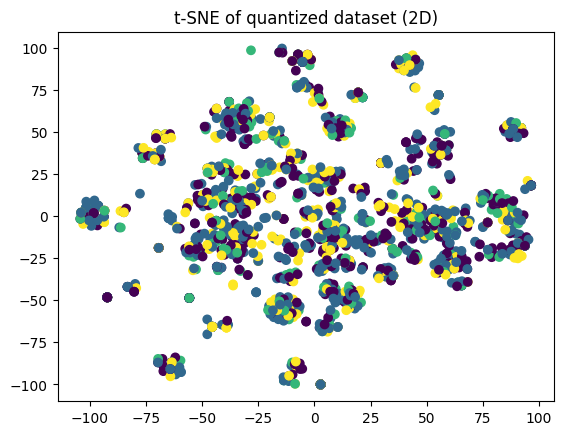

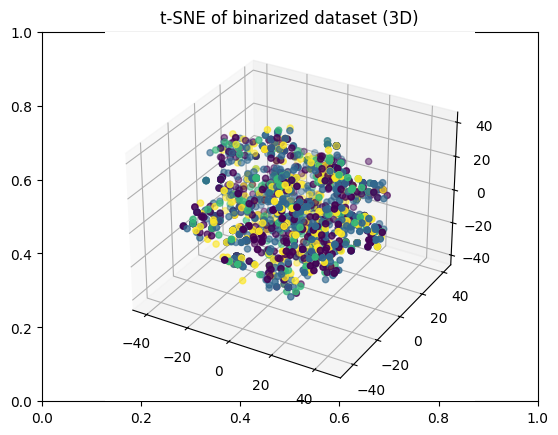

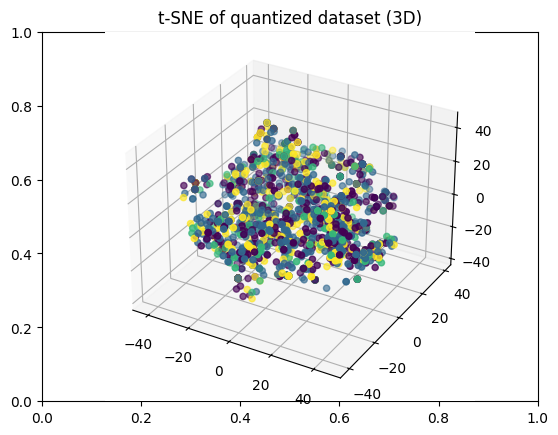

In [15]:
# first, let's reduce the dimensionality of the datasets for t-SNE to work properly using TruncatedSVD (since data is sparse)
svd_model_bin = TruncatedSVD(n_components=50)
X_bin_svd = svd_model_bin.fit_transform(X_bin)
svd_model_cat = TruncatedSVD(n_components=50)
X_cat_svd = svd_model_cat.fit_transform(X_cat)

# 2D t-SNE
tsne_model_bin_2d = TSNE(n_components=2, perplexity=30, max_iter=1000)
X_bin_tsne_2d = tsne_model_bin_2d.fit_transform(X_bin_svd)

tsne_model_cat_2d = TSNE(n_components=2, perplexity=30, max_iter=1000)
X_cat_tsne_2d = tsne_model_cat_2d.fit_transform(X_cat_svd)

plt.figure()
plt.title('t-SNE of binarized dataset (2D)')
plt.scatter(X_bin_tsne_2d[:, 0], X_bin_tsne_2d[:, 1], c=y_bin)

plt.figure()
plt.title('t-SNE of quantized dataset (2D)')
plt.scatter(X_cat_tsne_2d[:, 0], X_cat_tsne_2d[:, 1], c=y_cat)

# 3D t-SNE
tsne_model_bin_3d = TSNE(n_components=3, perplexity=30, max_iter=1000)
X_bin_tsne_3d = tsne_model_bin_3d.fit_transform(X_bin_svd)

tsne_model_cat_3d = TSNE(n_components=3, perplexity=30, max_iter=1000)
X_cat_tsne_3d = tsne_model_cat_3d.fit_transform(X_cat_svd)

from mpl_toolkits.mplot3d import Axes3D
plt.figure()
plt.title('t-SNE of binarized dataset (3D)')
ax = plt.axes(projection='3d')
ax.scatter(X_bin_tsne_3d[:, 0], X_bin_tsne_3d[:, 1], X_bin_tsne_3d[:, 2], c=y_bin)

plt.figure()
plt.title('t-SNE of quantized dataset (3D)')
ax = plt.axes(projection='3d')
ax.scatter(X_cat_tsne_3d[:, 0], X_cat_tsne_3d[:, 1], X_cat_tsne_3d[:, 2], c=y_cat);


## SMOTE


In [17]:
# Add a fixed number of datapoints per class WITH SMOTE (e.g., add 300 data points per each class)
# used for DataGen-2.2
# data: the dataset
# label_column: the name of the label column
# n_samples: the number points we want to add
# Output: the new dataset with the added points

def add_datapoints_SMOTE(data, label_column='label', n_samples=300, random_state=42):
    print(f"label distribution before adding points: {Counter(data[label_column])}")
    new_data = []

    # get all the classes
    classes = data[label_column].unique()

    for class_label in classes:
        class_data = data[data[label_column] == class_label]
        other_data = data[data[label_column] != class_label]
        X = class_data.drop(columns=label_column)
        y = class_data[label_column]

        X_smote = pd.concat([X, other_data.drop(columns=label_column)])
        y_smote = pd.concat([y, other_data[label_column]])

        # add points
        smote = SMOTE(sampling_strategy={class_label: len(class_data) + n_samples}, random_state=random_state)
        X_resampled, y_resampled = smote.fit_resample(X_smote, y_smote)

        # filter the new datas:
        new_class_data = X_resampled[y_resampled == class_label].iloc[len(class_data):]
        new_class_labels = y_resampled[y_resampled == class_label].iloc[len(class_data):]

        # add the new data into the old one
        resampled_data = pd.concat([pd.DataFrame(new_class_data, columns=X.columns), pd.DataFrame(new_class_labels, columns=[label_column])], axis=1)
        new_data.append(resampled_data)

    if new_data:
        new_data = pd.concat(new_data, axis=0)
        result_data = pd.concat([data, new_data], axis=0).reset_index(drop=True)

    print(f"label distribution after adding points: {Counter(result_data[label_column])}")
    return result_data

In [18]:
# Class re-balance using SMOTE (used for DataGen-1, DataGen-2.1)
# input: the data needed to be rebalance
# output: the data after rebalance of the classes (in NumPy format)

def balance_smote(X, y, label_column='label', random_state=42):
    print(f"label distribution before: {Counter(y)}")

    smote = SMOTE(random_state=random_state)

    # use smote
    X_resampled, y_resampled = smote.fit_resample(X, y)

    print(f"label distribution after: {Counter(y_resampled)}")
    return X_resampled, y_resampled

## GAN

In [19]:
# Helper function to get X and y from a DataFrame
def get_X_y(df):
    X = df.drop('label', axis=1).to_numpy()
    y = df['label'].to_numpy()
    return X, y

In [21]:
# Helper function to get a DataFrame from X and y (optimized: less warnings)
def create_df(X, y):
    # Create a list of DataFrames for each column in X
    columns = [pd.DataFrame(X[:, i], columns=[f'alarm_renumbered_{i}']) for i in range(X.shape[1])]
    # Concatenate all columns along the columns axis (axis=1)
    df = pd.concat(columns, axis=1)
    df['label'] = y
    return df

In [22]:
# Balance a dataset using GAN (or add a fixed number of samples)
# input: - data: the data needed to be rebalance
#        - label_column: the name of the label column
#        - random_state: the random state
#        - fixed_number_of_samples: the number of samples to generate for each class, if None: rebalance the classes

# outputs: - ctgan: the trained CTGAN model
#          - balanced_data: the data after rebalance of the classes
#          - synthetic_data: the (new) synthetic data generated (subset of balanced_data)
#          - metadata: the metadata of the data

def balance_gan(
    data,
    label_column="label",
    random_state=42,
    fixed_number_of_samples: Optional[int] = None,
):
    # Split data by class
    data = data.sample(frac=1, random_state=random_state).reset_index(drop=True)
    class_data = data.groupby(label_column)
    for cls, subset in class_data:
        print(f"Class {cls} has {len(subset)} samples")

    # Determine target class size (size of the largest class)
    if not fixed_number_of_samples:
        target_size = class_data.size().max()
        print(f"Majority class size: {target_size}")

    # Generate synthetic data for minority classes
    synthetic_data = pd.DataFrame()
    metadata = SingleTableMetadata()
    metadata.detect_from_dataframe(data)

    # Initialize and fit the CTGANSynthesizer
    ctgan = CTGANSynthesizer(metadata=metadata, epochs=600)
    ctgan.fit(data)

    # Calculate the number of samples needed for each class
    if fixed_number_of_samples:
        samples_needed = {cls: fixed_number_of_samples for cls, _ in class_data}
    else:
        samples_needed = {cls: target_size - len(subset) for cls, subset in class_data}
        print(f"Samples needed to evenly balance: {samples_needed}")

    # Generate conditions for each class to do conditional sampling
    conditions = [
        Condition(column_values={label_column: cls}, num_rows=samples_needed[cls])
        for cls in samples_needed
    ]

    # Sample synthetic data for each class
    synthetic_data = ctgan.sample_from_conditions(conditions=conditions)
    
    # Combine original and synthetic data
    balanced_data = pd.concat([data, synthetic_data], ignore_index=True)

    return ctgan, balanced_data, synthetic_data, metadata

In [23]:
#ctgan, evenly_balanced_dataset, evenly_synthentic_data, evenly_metadata = balance_gan(
#    df_processed
#)
#ctgan2, fixed_add_dataset, fixed_synthetic_data, fix_metadata = balance_gan(
#    df_processed, fixed_number_of_samples=300
#)

In [24]:
#evenly_balanced_dataset

In [25]:
# save models
#ctgan.save('ctgan_evenly_balanced.pkl')
#ctgan2.save('ctgan_fixed_balanced.pkl')

In [26]:
# reload models
#ctgan = CTGANSynthesizer.load('ctgan_evenly_balanced.pkl')
#ctgan2 = CTGANSynthesizer.load('ctgan_fixed_balanced.pkl')

## Cross-validation and testing with data generation (wrapper function)

In [ ]:
# Remove X% of the data points of class Y from the training set
# used for DataGen-2
# class_label: 0/1/2/3
def remove_class_percentage(data, class_label, percentage, label_column='label'):
    X = data.drop(columns=label_column)
    y = data[label_column]
    print(f"label distribution before remove points: {Counter(y)}")

    class_data = data[data[label_column] == class_label]
    # find the number of the data needed to be deleted
    num_to_remove = int(len(class_data) * (percentage / 100))

    indices_to_remove = np.random.choice(class_data.index, size=num_to_remove, replace=False)

    data_remaining = data.drop(indices_to_remove)
    X = data_remaining.drop(columns=label_column)
    y = data_remaining[label_column]
    print(f"label distribution after remove points: {Counter(y)}")

    return data_remaining

In [99]:
# Train and test a selected model on the specified dataset, possibly generating synthetic data, using a specified algorithm. Display the confusion matrix for each fold.
# input: - X: the feature matrix
#        - y: the ground truth labels
#        - k_test: the number of folds for the outer cross-validation (test set - averaging performances)
#        - k_valid: the number of folds for the inner cross-validation (validation set - hyperparameter tuning)
#        - model: the classifier to be used (KNN, RF, XGB, MLP, SVM)
#        - data_gen_algorithm: the algorithm to be used for data generation (GAN, SMOTE)
#        - fixed_n_samples: the number of samples to generate for each class (if None: rebalance the classes)
# output: the average weighted macro F1 score on the test sets

def train_and_test_model(
    X, y, 
    k_test=5, 
    k_valid=5, 
    model='KNN', 
    data_gen_algorithm=None, 
    fixed_n_samples: Optional[int] = None
):
    # Test set, used for averaging performance
    outer_kf = StratifiedKFold(n_splits=k_test, random_state=42, shuffle=True)
    accuracies = []
    f1_scores = []
    for i, (train_index, test_index) in enumerate(outer_kf.split(X, y)):

        # Split data into (training + validation) and test set
        X_tmp, X_test = X[train_index], X[test_index]
        y_tmp, y_test = y[train_index], y[test_index]

        print(X_tmp.shape, X_test.shape, y_tmp.shape, y_test.shape)

        # Handle data generation based on the specified algorithm and data version
        if data_gen_algorithm == 'GAN':
            if fixed_n_samples is None:
                X_tmp, y_tmp = get_X_y(balance_gan(create_df(X_tmp, y_tmp), label_column='label')[1])
                display(create_df(X_tmp, y_tmp))
            else:
                result_data = remove_class_percentage(create_df(X_tmp, y_tmp), class_label=2, percentage=80)
                if data_version == '2.1':
                    X_tmp, y_tmp = get_X_y(balance_gan(result_data, label_column='label', random_state=42, fixed_number_of_samples=fixed_n_samples)[1])
                elif data_version == '2.2':
                    X_tmp, y_tmp = get_X_y(balance_gan(result_data, label_column='label', random_state=42)[1])
                display(create_df(X_tmp, y_tmp))
        elif data_gen_algorithm == 'SMOTE':
            if fixed_n_samples is None:
                X_tmp, y_tmp = balance_smote(X_tmp, y_tmp)
                display(create_df(X_tmp, y_tmp))
            else:
                result_data = remove_class_percentage(create_df(X_tmp, y_tmp), class_label=2, percentage=80)
                if data_version == '2.1':
                    result_data = add_datapoints_SMOTE(result_data, label_column='label', n_samples=fixed_n_samples, random_state=42)
                    X_tmp, y_tmp = get_X_y(result_data)
                elif data_version == '2.2':
                    X_tmp, y_tmp = balance_smote(get_X_y(result_data))
                display(create_df(X_tmp, y_tmp))

        # Cross-validate model, using i-th fold
        if model == 'KNN':
            best_model, _ = optimize_KNN(X_tmp, y_tmp, k=k_valid)
        elif model == 'RF':
            best_model, _ = optimize_RF(X_tmp, y_tmp, k=k_valid)
        elif model == 'XGB':
            best_model, _ = optimize_XGB(X_tmp, y_tmp, k=k_valid)
        elif model == 'MLP':
            best_model, _ = optimize_MLP(X_tmp, y_tmp, k=k_valid)
        elif model == 'SVM':
            best_model, _ = optimize_SVM(X_tmp, y_tmp, k=k_valid)
        else: raise ValueError('Model not supported. Please choose between KNN, RF, XGB, MLP, SVM.')

        # Accuracy on test set
        y_test_pred = best_model.predict(X_test)
        test_set_accuracy = np.mean(y_test_pred == y_test)
        test_set_f1 = f1_score(y_test, y_test_pred, average='weighted')
        accuracies.append(test_set_accuracy)
        f1_scores.append(test_set_f1)
        print(f'{i+1}th fold test set accuracy: {test_set_accuracy}')
        print(f'{i+1}th fold test set f1 score: {test_set_f1}')
    
        # Display confusion matrix
        cm = confusion_matrix(y_test, y_test_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

    return sum(accuracies) / len(accuracies)

(1335, 164) (334, 164) (1335,) (334,)
  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 20/20 [00:07<00:00,  2.52trial/s, best loss: -0.3016218043977902] 
{'estimators': 0, 'max_depth': 11, 'subsample': 2}
{'estimators': 1, 'max_depth': 12, 'subsample': 0.12}
best_cv_acc: 0.3
Crossvalidation duration for RF is 8 s

Best number of estimators: 1

Best max depth: 12

Best subsample rate: 0.12

Crossvalidation accuracy: 0.3

Training duration for RF is 0 s

1th fold test set accuracy: 0.27844311377245506
1th fold test set f1 score: 0.2685595343199817


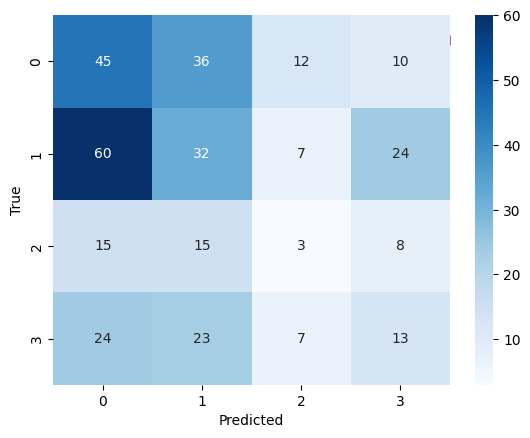

(1335, 164) (334, 164) (1335,) (334,)
100%|██████████| 20/20 [00:10<00:00,  1.98trial/s, best loss: -0.3257773761600272]
{'estimators': 14, 'max_depth': 14, 'subsample': 18}
{'estimators': 15, 'max_depth': 15, 'subsample': 0.2799999999999999}
best_cv_acc: 0.33
Crossvalidation duration for RF is 10 s

Best number of estimators: 15

Best max depth: 15

Best subsample rate: 0.2799999999999999

Crossvalidation accuracy: 0.33

Training duration for RF is 0 s

2th fold test set accuracy: 0.3143712574850299
2th fold test set f1 score: 0.29513283279789637


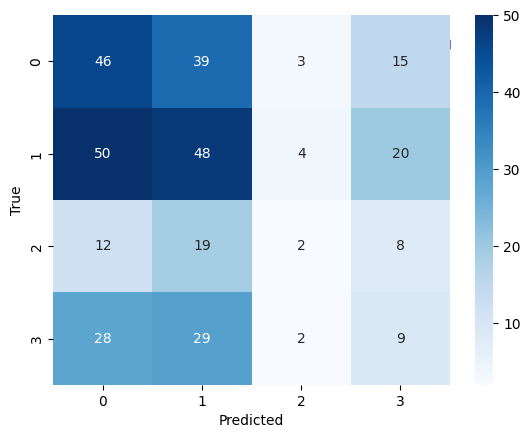

(1335, 164) (334, 164) (1335,) (334,)
100%|██████████| 20/20 [00:08<00:00,  2.42trial/s, best loss: -0.3094395863200523]
{'estimators': 11, 'max_depth': 10, 'subsample': 19}
{'estimators': 12, 'max_depth': 11, 'subsample': 0.2899999999999999}
best_cv_acc: 0.31
Crossvalidation duration for RF is 8 s

Best number of estimators: 12

Best max depth: 11

Best subsample rate: 0.2899999999999999

Crossvalidation accuracy: 0.31

Training duration for RF is 0 s

3th fold test set accuracy: 0.344311377245509
3th fold test set f1 score: 0.29835700740362575


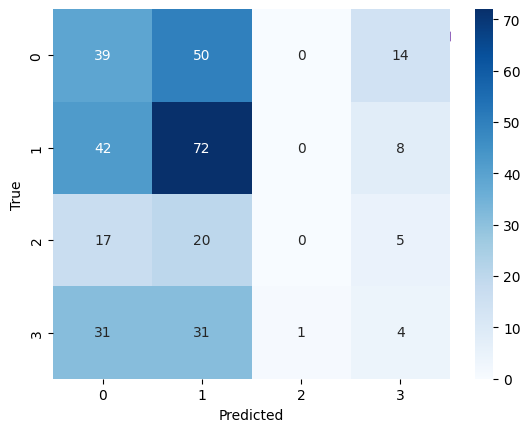

(1335, 164) (334, 164) (1335,) (334,)
100%|██████████| 20/20 [00:09<00:00,  2.09trial/s, best loss: -0.29935651732129465]
{'estimators': 15, 'max_depth': 9, 'subsample': 32}
{'estimators': 16, 'max_depth': 10, 'subsample': 0.4199999999999998}
best_cv_acc: 0.3
Crossvalidation duration for RF is 10 s

Best number of estimators: 16

Best max depth: 10

Best subsample rate: 0.4199999999999998

Crossvalidation accuracy: 0.3

Training duration for RF is 0 s

4th fold test set accuracy: 0.3592814371257485
4th fold test set f1 score: 0.30880475074695324


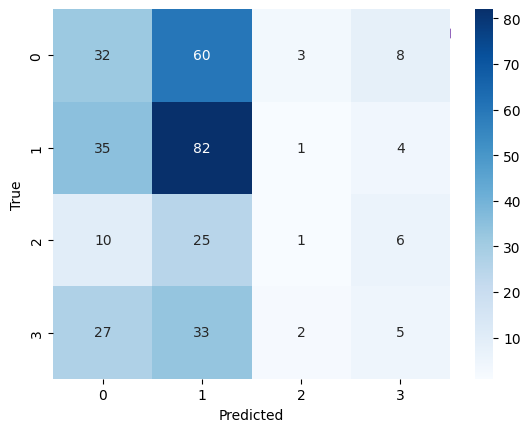

(1336, 164) (333, 164) (1336,) (333,)
100%|██████████| 20/20 [00:14<00:00,  1.41trial/s, best loss: -0.3114579263468658]
{'estimators': 13, 'max_depth': 5, 'subsample': 47}
{'estimators': 14, 'max_depth': 6, 'subsample': 0.5699999999999997}
best_cv_acc: 0.31
Crossvalidation duration for RF is 14 s

Best number of estimators: 14

Best max depth: 6

Best subsample rate: 0.5699999999999997

Crossvalidation accuracy: 0.31

Training duration for RF is 0 s

5th fold test set accuracy: 0.35735735735735735
5th fold test set f1 score: 0.3072026371310483


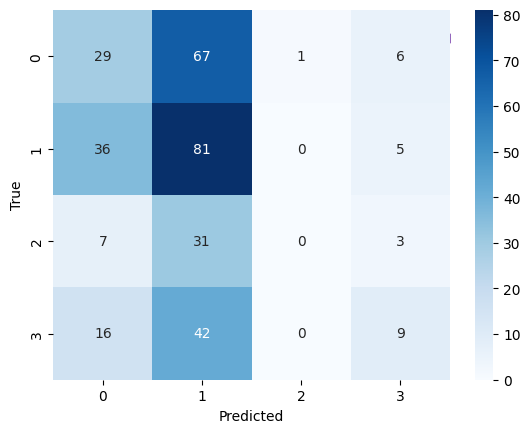

In [50]:
acc = train_and_test_model(X=X_bin, y=y_bin, k_test=5, k_valid=5, model='XGB')

(654, 164) (164, 164) (654,) (164,)
100%|██████████| 20/20 [00:02<00:00,  7.10trial/s, best loss: -0.6585416543762486]
{'estimators': 8, 'max_depth': 5, 'subsample': 19}
{'estimators': 9, 'max_depth': 6, 'subsample': 0.2899999999999999}
best_cv_acc: 0.66
Crossvalidation duration for RF is 3 s

Best number of estimators: 9

Best max depth: 6

Best subsample rate: 0.2899999999999999

Crossvalidation accuracy: 0.66

Training duration for RF is 0 s

1th fold test set accuracy: 0.6951219512195121
1th fold test set f1 score: 0.6455938697318007


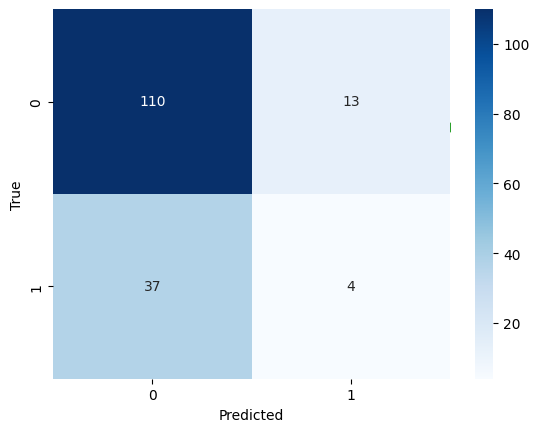

(654, 164) (164, 164) (654,) (164,)
100%|██████████| 20/20 [00:03<00:00,  6.08trial/s, best loss: -0.672073417314309] 
{'estimators': 9, 'max_depth': 9, 'subsample': 60}
{'estimators': 10, 'max_depth': 10, 'subsample': 0.6999999999999996}
best_cv_acc: 0.67
Crossvalidation duration for RF is 3 s

Best number of estimators: 10

Best max depth: 10

Best subsample rate: 0.6999999999999996

Crossvalidation accuracy: 0.67

Training duration for RF is 0 s

2th fold test set accuracy: 0.7012195121951219
2th fold test set f1 score: 0.6383194041730627


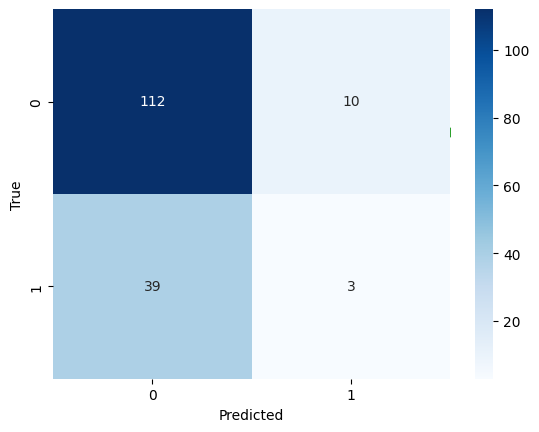

(654, 164) (164, 164) (654,) (164,)
100%|██████████| 20/20 [00:02<00:00,  7.54trial/s, best loss: -0.663833148785061] 
{'estimators': 12, 'max_depth': 10, 'subsample': 6}
{'estimators': 13, 'max_depth': 11, 'subsample': 0.15999999999999998}
best_cv_acc: 0.66
Crossvalidation duration for RF is 3 s

Best number of estimators: 13

Best max depth: 11

Best subsample rate: 0.15999999999999998

Crossvalidation accuracy: 0.66

Training duration for RF is 0 s

3th fold test set accuracy: 0.7378048780487805
3th fold test set f1 score: 0.6316645271715875


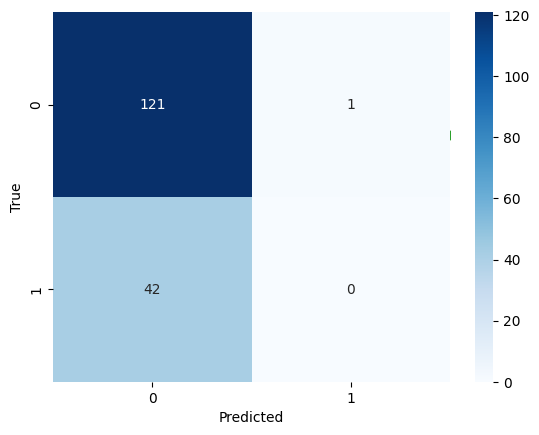

(655, 164) (163, 164) (655,) (163,)
100%|██████████| 20/20 [00:02<00:00,  7.51trial/s, best loss: -0.6502786744983629]
{'estimators': 11, 'max_depth': 8, 'subsample': 53}
{'estimators': 12, 'max_depth': 9, 'subsample': 0.6299999999999997}
best_cv_acc: 0.65
Crossvalidation duration for RF is 3 s

Best number of estimators: 12

Best max depth: 9

Best subsample rate: 0.6299999999999997

Crossvalidation accuracy: 0.65

Training duration for RF is 0 s

4th fold test set accuracy: 0.7423312883435583
4th fold test set f1 score: 0.648425911642202


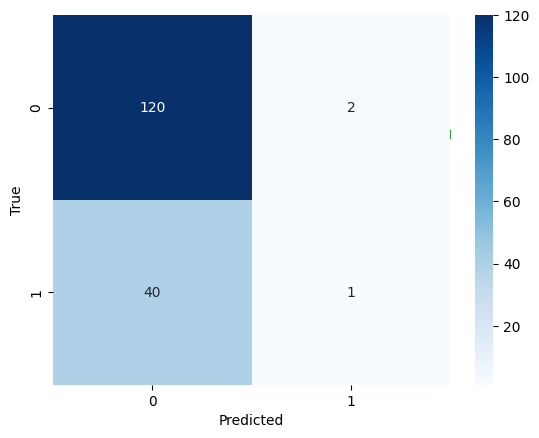

(655, 164) (163, 164) (655,) (163,)
100%|██████████| 20/20 [00:02<00:00,  7.07trial/s, best loss: -0.6562075313052059]
{'estimators': 17, 'max_depth': 8, 'subsample': 67}
{'estimators': 18, 'max_depth': 9, 'subsample': 0.7699999999999997}
best_cv_acc: 0.66
Crossvalidation duration for RF is 3 s

Best number of estimators: 18

Best max depth: 9

Best subsample rate: 0.7699999999999997

Crossvalidation accuracy: 0.66

Training duration for RF is 0 s

5th fold test set accuracy: 0.7300613496932515
5th fold test set f1 score: 0.6417863811302061


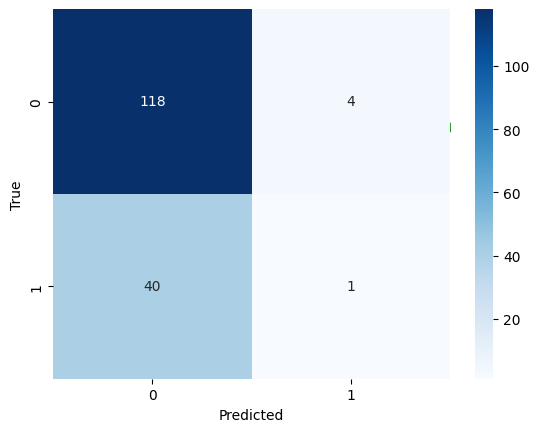

In [42]:
# masked
acc = train_and_test_model(X=X_bin_masked, y=y_bin_masked, k_test=5, k_valid=5, model='XGB')

In [28]:
# under-sampled BIN
acc = train_and_test_model(X=X_cat_resampled, y=y_cat_resampled, k_test=5, k_valid=5, model='RF')
print(acc)

(662, 164) (166, 164) (662,) (166,)


Estimators: 10, Criterion: gini, Max Depth: 3, F1: 0.19212144960329067
Estimators: 10, Criterion: gini, Max Depth: 15, F1: 0.21440379120045056
Estimators: 10, Criterion: gini, Max Depth: None, F1: 0.1851470762446971
Estimators: 10, Criterion: entropy, Max Depth: 3, F1: 0.20381823826149592
Estimators: 10, Criterion: entropy, Max Depth: 15, F1: 0.1951958511350506
Estimators: 10, Criterion: entropy, Max Depth: None, F1: 0.18233782052971625
Estimators: 50, Criterion: gini, Max Depth: 3, F1: 0.22061159954045556
Estimators: 50, Criterion: gini, Max Depth: 15, F1: 0.18194106600462231
Estimators: 50, Criterion: gini, Max Depth: None, F1: 0.20369699676873618
Estimators: 50, Criterion: entropy, Max Depth: 3, F1: 0.19890529782439484
Estimators: 50, Criterion: entropy, Max Depth: 15, F1: 0.18014584214192592
Estimators: 50, Criterion: entropy, Max Depth: None, F1: 0.20308409922873438
Estimators: 100, Criterion: gini, Max Depth: 3, F1: 0.20804471792903662
Estimators: 100, Criterion: gini, Max Depth: